In [11]:
from pathlib import Path
import requests
from openmm_utility import *

In [7]:
# create data directory if not exists
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATA.mkdir(exist_ok=True)

In [29]:
pdbid = "2DRI"
ligand_name = "RIP"
pdb_path = DATA / f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

In [30]:
r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

In [31]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

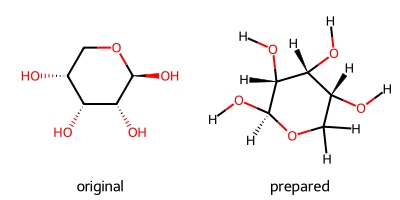

In [32]:
smiles = "C1[C@H]([C@H]([C@H]([C@@H](O1)O)O)O)O"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

In [33]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

In [34]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 4729 atoms.


/Users/chenlin/opt/anaconda3/envs/openmm/lib/python3.8/site-packages/openmm/unit/quantity.py:750: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [35]:
forcefield = generate_forcefield(rdkit_ligand)

In [36]:
princed_position, box_size = align_princ(complex_topology, complex_positions)
modeller = app.Modeller(complex_topology, princed_position)
modeller.addSolvent(forcefield, boxSize=box_size, ionicStrength=0.15 * unit.molar)

In [37]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = openmm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [38]:
#simulation.minimizeEnergy()
with open(DATA / "topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )